In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('train.csv')
df.drop(['Name','Ticket','Cabin','PassengerId'],1,inplace=True)
df.replace({'male':1,'female':0},inplace=True)
max=df['Embarked'].mode()
df=df.fillna(max)
df.replace({'S':0,'C':1,'Q':2},inplace=True)
df['Age']=df['Age'].interpolate()
df=df.dropna()
X=np.array(df.drop(['Survived'],1))
Y=np.array(df['Survived'])

In [40]:
X_flatten=X.reshape(X.shape[0],-1).T
Y_flatten=Y.reshape(Y.shape[0],1)
X_normalized=sklearn.preprocessing.normalize(X_flatten)

In [41]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache


In [5]:
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache



In [6]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [7]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ



In [8]:
def initialize_parameters_deep(layer_dims):
    parameters={}
    L=len(layer_dims) #no. of layers in the network 
    for l in range(1,L):
        parameters['W'+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])*0.001
        parameters['b'+str(l)]=np.zeros((layer_dims[l],1))
    return parameters

In [9]:
def linear_forward(A,W,b):
    Z=np.dot(W,A)+b
    cache=(A,W,b)
    return Z,cache

In [10]:
def linear_activation_forward(A_prev, W,b,activation):
    if activation=='sigmoid':
        Z,linear_cache=linear_forward(A_prev,W,b)
        A,activation_cache=sigmoid(Z)
    elif activation=='relu':
        Z,linear_cache=linear_forward(A_prev,W,b)
        A,activation_cache=relu(Z)
    cache=(linear_cache, activation_cache)
    return A,cache
    

In [11]:
def L_model_forward(X,parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],activation='relu')
        caches.append(cache)
        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache = linear_activation_forward(A,parameters["W"+str(L)],parameters["b"+str(L)],activation='sigmoid')
    caches.append(cache)
    ### END CODE HERE ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches


In [42]:
def compute_cost(AL,Y):
    m=Y.shape[0]
    cost = (-1/m)*np.sum(Y.T*np.log(AL)+(1-Y.T)*np.log(1-AL))
    cost=np.squeeze(cost)
    return cost


In [43]:
def linear_backward(dZ,cache):
    A_prev,W,b=cache
    m=A_prev.shape[1]
    dW=(1/889)*np.dot(dZ,A_prev.T)
    db = (1/889)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev,dW,db

In [44]:
def linear_activation_backward(dA,cache,activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    return dA_prev, dW, db

    

In [45]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL =- (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(sigmoid_backward(dAL,current_cache[1]),current_cache[0])
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_backward(sigmoid_backward(dAL, current_cache[1]), current_cache[0])
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads
    
    

In [46]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W"+str(l+1)]-=learning_rate*grads['dW'+str(l+1)]
        parameters["b"+str(l+1)]-=learning_rate*grads['db'+str(l+1)]
    return parameters
    

In [47]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.00075, num_iterations = 3000, print_cost=False):
    costs = []    
    parameters=initialize_parameters_deep(layers_dims)
#     Starting gradient descent 
    for i in range(0, num_iterations):
        AL,caches=L_model_forward(X,parameters)
        cost=compute_cost(AL,Y)
        grads=L_model_backward(AL,Y,caches)
        parameters=update_parameters(parameters, grads, learning_rate)
        if print_cost and i%100 ==0:
            print("Cost after iteration %i: %f " %(i,cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters

            
            

In [57]:
layers_dims = [7, 120, 100, 20,18, 1]

Cost after iteration 0: 0.693147 
Cost after iteration 100: 0.690895 
Cost after iteration 200: 0.688826 
Cost after iteration 300: 0.686926 
Cost after iteration 400: 0.685180 
Cost after iteration 500: 0.683577 
Cost after iteration 600: 0.682104 
Cost after iteration 700: 0.680751 
Cost after iteration 800: 0.679507 
Cost after iteration 900: 0.678365 
Cost after iteration 1000: 0.677315 
Cost after iteration 1100: 0.676350 
Cost after iteration 1200: 0.675463 
Cost after iteration 1300: 0.674648 
Cost after iteration 1400: 0.673899 
Cost after iteration 1500: 0.673210 
Cost after iteration 1600: 0.672577 
Cost after iteration 1700: 0.671994 
Cost after iteration 1800: 0.671459 
Cost after iteration 1900: 0.670966 
Cost after iteration 2000: 0.670513 
Cost after iteration 2100: 0.670096 
Cost after iteration 2200: 0.669713 
Cost after iteration 2300: 0.669360 
Cost after iteration 2400: 0.669035 
Cost after iteration 2500: 0.668737 
Cost after iteration 2600: 0.668462 
Cost after it

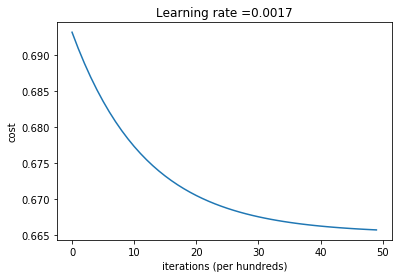

In [58]:
parameters=L_layer_model(X_normalized,Y_flatten,layers_dims,learning_rate=0.00170,num_iterations=5000,print_cost=True)

In [59]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = L_model_forward(X,parameters)
    print(A2)
    predictions=A2>0.5
    ### END CODE HERE ###
    
    return predictions


# In[93]:


In [60]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


In [61]:
df1=pd.read_csv('test_titanic.csv')

In [62]:
df1.drop(['Name','Ticket','Cabin','PassengerId'],1,inplace=True)
df1.replace({'male':1,'female':0},inplace=True)
max=df1['Embarked'].mode()
df1=df1.fillna(max)
df1.replace({'S':0,'C':1,'Q':2},inplace=True)
df1['Age']=df1['Age'].interpolate()
df1=df1.dropna()
X_test=np.array(df1)


In [63]:
X_test=X_test.reshape(7,417)
Xtest_normalized=sklearn.preprocessing.normalize(X_test)

In [64]:
A=np.array([3,0,24,1,1,8.90,0])
A=A.reshape(7,1)
print(A.shape)
predict(parameters,A)

(7, 1)
[[0.39715748]]


array([[False]])

In [65]:
df1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,2
1,3,0,47.0,1,0,7.0000,0
2,2,1,62.0,0,0,9.6875,2
3,3,1,27.0,0,0,8.6625,0
4,3,0,22.0,1,1,12.2875,0


In [68]:
c=predict(parameters, Xtest_normalized)
print(c.shape)

[[0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.39715748 0.39715748
  0.39715748 0.39715748 0.39715748 0.39715748 0.